In [4]:
import numpy as np

class UAVEnvironment:
    def __init__(self, service_nodes, charging_stations, depot, battery_capacity):
        self.service_nodes = service_nodes.copy()
        self.charging_stations = charging_stations
        self.depot = depot
        self.battery_capacity = battery_capacity
        self.state = self.reset()

    def reset(self):
        self.position = self.depot
        self.battery_level = self.battery_capacity
        self.visited = {node: False for node in self.service_nodes}
        return self.get_state()

    def get_state(self):
        state = np.zeros(len(self.service_nodes) + 2)
        state[0] = self.position[0]
        state[1] = self.position[1]
        for idx, node in enumerate(self.service_nodes):
            state[idx+2] = self.visited[node]
        return state

    def step(self, action):
        next_node, charge = action
        reward = -1  # Small penalty for each move
        if charge and next_node in self.charging_stations:
            if self.battery_level <= 20:
                reward += 10  # Reward for charging
            else:
                reward -= 5  # Penalty for charging
            self.battery_level = self.battery_capacity
           
        else:
            if next_node in self.service_nodes and not self.visited[next_node]:
                self.visited[next_node] = True
                if self.battery_level <= 20:
                    reward -= 5  # Penalty for visiting a new service node
                else:
                    reward += 10 # Reward for visiting a new service node
            elif next_node in self.service_nodes and self.visited[next_node]:
                if self.battery_level <= 20:
                    reward -= 30  # Penalty for visiting a prev service node with low battery
                else:
                    reward -= 20 # Penalty for visiting a prev service node with good amount of battery

        # Compute distance and battery cost
        distance = np.linalg.norm(np.array(self.position) - np.array(next_node))
        self.battery_level -= distance
        self.position = next_node

        if self.battery_level <= 0:
            reward -= 50  # Heavy penalty for running out of battery
            done = True
        else:
            done = False
            if all(self.visited.values()):
                reward += 100
                done = True
                self.position == self.depot

        return self.get_state(), reward, done

    def valid_actions(self):
        actions = []
        for node in self.service_nodes + self.charging_stations:
            actions.append((node, False))  # Move without charging
            if node in self.charging_stations:
                actions.append((node, True))  # Move and charge
        return actions

In [3]:
pip install torch


                                              0.0/198.6 MB ? eta -:--:--
                                              0.1/198.6 MB 1.3 MB/s eta 0:02:36
                                              0.2/198.6 MB 2.1 MB/s eta 0:01:35
                                              0.3/198.6 MB 2.6 MB/s eta 0:01:16
                                              0.6/198.6 MB 3.5 MB/s eta 0:00:58
                                              1.1/198.6 MB 4.8 MB/s eta 0:00:42
                                              1.1/198.6 MB 5.0 MB/s eta 0:00:40
                                              1.1/198.6 MB 5.0 MB/s eta 0:00:40
                                              1.3/198.6 MB 3.7 MB/s eta 0:00:54
                                              1.5/198.6 MB 4.1 MB/s eta 0:00:49
                                              1.5/198.6 MB 3.3 MB/s eta 0:01:00
                                              2.0/198.6 MB 4.2 MB/s eta 0:00:48
                                              

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.2 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, output_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))  # Compute Q value from V and A
        return Q

class Agent:
    def __init__(self, input_dim, output_dim, lr=0.005):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.net = DuelingDQN(input_dim, output_dim).to(self.device)
        self.target_net = DuelingDQN(input_dim, output_dim).to(self.device)
        self.target_net.load_state_dict(self.net.state_dict())
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if random.random() < self.epsilon:
            return random.randint(0, self.net.fc2.out_features - 1)
        else:
            q_values = self.net(state_t)
            return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_t = torch.FloatTensor(states).to(self.device)
        actions_t = torch.LongTensor(actions).to(self.device)
        rewards_t = torch.FloatTensor(rewards).to(self.device)
        next_states_t = torch.FloatTensor(next_states).to(self.device)
        dones_t = torch.BoolTensor(dones).to(self.device)

        current_q = self.net(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
        next_q = self.target_net(next_states_t).max(1)[0]
        expected_q = rewards_t + self.gamma * next_q * (~dones_t)

        loss = nn.MSELoss()(current_q, expected_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_net.load_state_dict(self.net.state_dict())

Episode 1, Total Reward: 64
Episode 2, Total Reward: 105
Episode 3, Total Reward: 103
Episode 4, Total Reward: 95
Episode 5, Total Reward: 99
Episode 6, Total Reward: 98
Episode 7, Total Reward: 106
Episode 8, Total Reward: 97
Episode 9, Total Reward: 108
Episode 10, Total Reward: 57
Episode 11, Total Reward: 112
Episode 12, Total Reward: 111
Episode 13, Total Reward: 112
Episode 14, Total Reward: 112
Episode 15, Total Reward: 112
Episode 16, Total Reward: 112
Episode 17, Total Reward: 112
Episode 18, Total Reward: 112
Episode 19, Total Reward: 112
Episode 20, Total Reward: 112
Episode 21, Total Reward: 112
Episode 22, Total Reward: 112
Episode 23, Total Reward: 106
Episode 24, Total Reward: 112
Episode 25, Total Reward: 106
Episode 26, Total Reward: 112
Episode 27, Total Reward: 112
Episode 28, Total Reward: 112
Episode 29, Total Reward: 112
Episode 30, Total Reward: 112
Episode 31, Total Reward: 112
Episode 32, Total Reward: 112
Episode 33, Total Reward: 106
Episode 34, Total Reward:

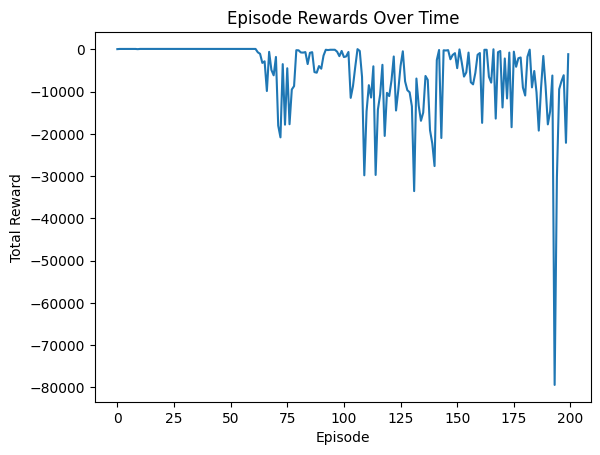

In [6]:
def train(agent, environment, episodes, batch_size):
    rewards = []
    for episode in range(episodes):
        total_reward = 0
        state = environment.reset()
        done = False
        while not done:
            valid_actions = environment.valid_actions()
            action = agent.select_action(state)
            if action >= len(valid_actions):
                continue
            next_state, reward, done = environment.step(environment.valid_actions()[action])
            agent.store_transition(state, action, reward, next_state, done)
            agent.replay(batch_size)
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
        if episode % 20 == 0:
            agent.update_target_network()
        print(f'Episode {episode+1}, Total Reward: {total_reward}')
    return rewards

# Define the environment
env = UAVEnvironment(service_nodes=[(1, 1), (2, 2), (3, 3)], charging_stations=[(2, 1), (3, 2)], depot=(0, 0), battery_capacity=100)

# Initialize the agent
agent = Agent(input_dim=5, output_dim=len(env.valid_actions()))

# Train the agent
episode_rewards = train(agent, env, 200, 64)

import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()